# Setup

In [1]:
import os
from pathlib import Path
# os chri to cur
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_loader import scores_df

null performances after coercion: 0
after filter num benchmarks 1965
after merge with model versions 1965
after date filter (>= 2022-11-01) 1766
after merge with benchmark dates 1766
Original number of rows: 1766
Number of rows after aggregation: 1324


In [3]:

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    '#00A5A6',  # teal
    '#E03D90',  # pink
    '#FC6538',  # orange
    '#6A3ECB',  # purple
    '#0058DC',  # blue
    '#EA8D00',  # yellow
    '#B087F4',  # lightPurple
    '#279E27',  # green
    '#009AF1',  # lightBlue
    '#015D90',  # darkBlue
    '#EA4831',  # red
    '#E1C700',  # yellow2
    '#46FFFF',  # turquoise
    '#63F039',  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",        # or "darkgrid", "ticks", "white"
    palette=custom_colors,    # your custom color palette
    context="notebook"        # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    
    # Axes
    "axes.titley": 1.02,
    "axes.titlesize": 14,
    "axes.titlelocation": 'center',
    "axes.titlepad": 0,
    "axes.labelsize": 12,
    "axes.labelpad": 10,           # spacing between axis and label
    "axes.spines.top": False,
    "axes.spines.right": False,
    
    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # tick marks size
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    
    # tick visibility
    "xtick.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": False,
    
    # Legend
    "legend.fontsize": 10,
    "legend.loc": "upper left",
    "legend.frameon": True,
    "legend.borderaxespad": 0,

    
    # Lines and markers
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.markeredgecolor": 'auto',   # white outline (stroke)
    "lines.markeredgewidth": 0.5,   
    # title alignment left
    

    
    
    # Error bars
    "errorbar.capsize": 3,
    
    # Font
    "font.family": "Arial",
    "font.sans-serif": ["DejaVu Sans"],
    
    # Grid
    "grid.alpha": 0.3,
    "grid.linestyle": "-",
    "grid.color": "lightgray",
})


# Figure 10: Benchmark overlap (Appendix B Data)

{'most_covered_benchmark': ('GPQA diamond', 102),
 'most_evaluated_model': ('claude-3-7-sonnet-20250219', 20)}

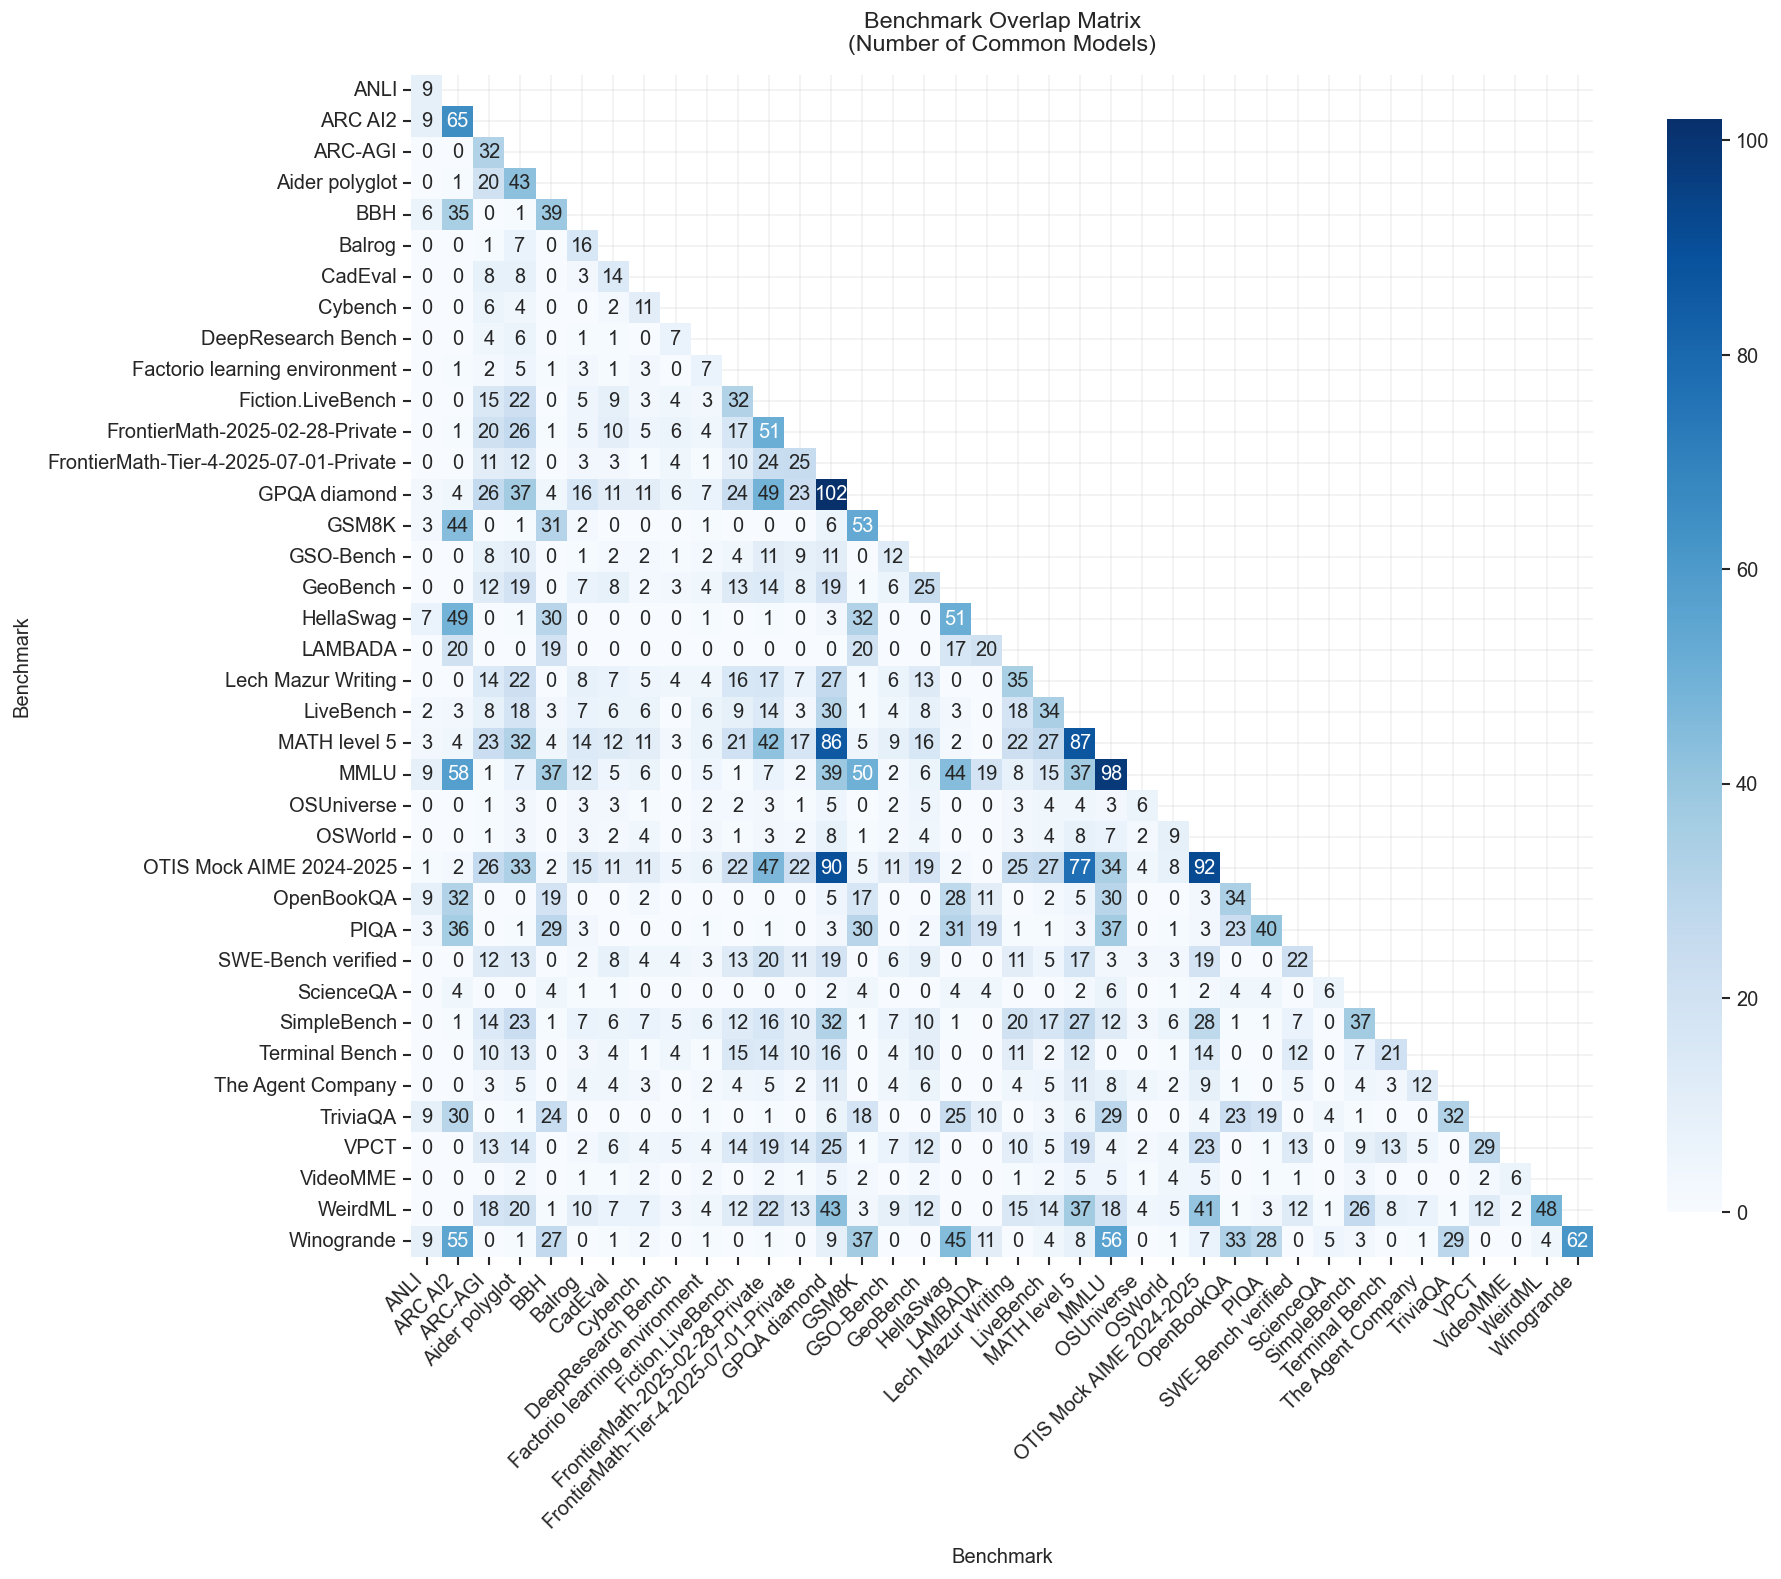

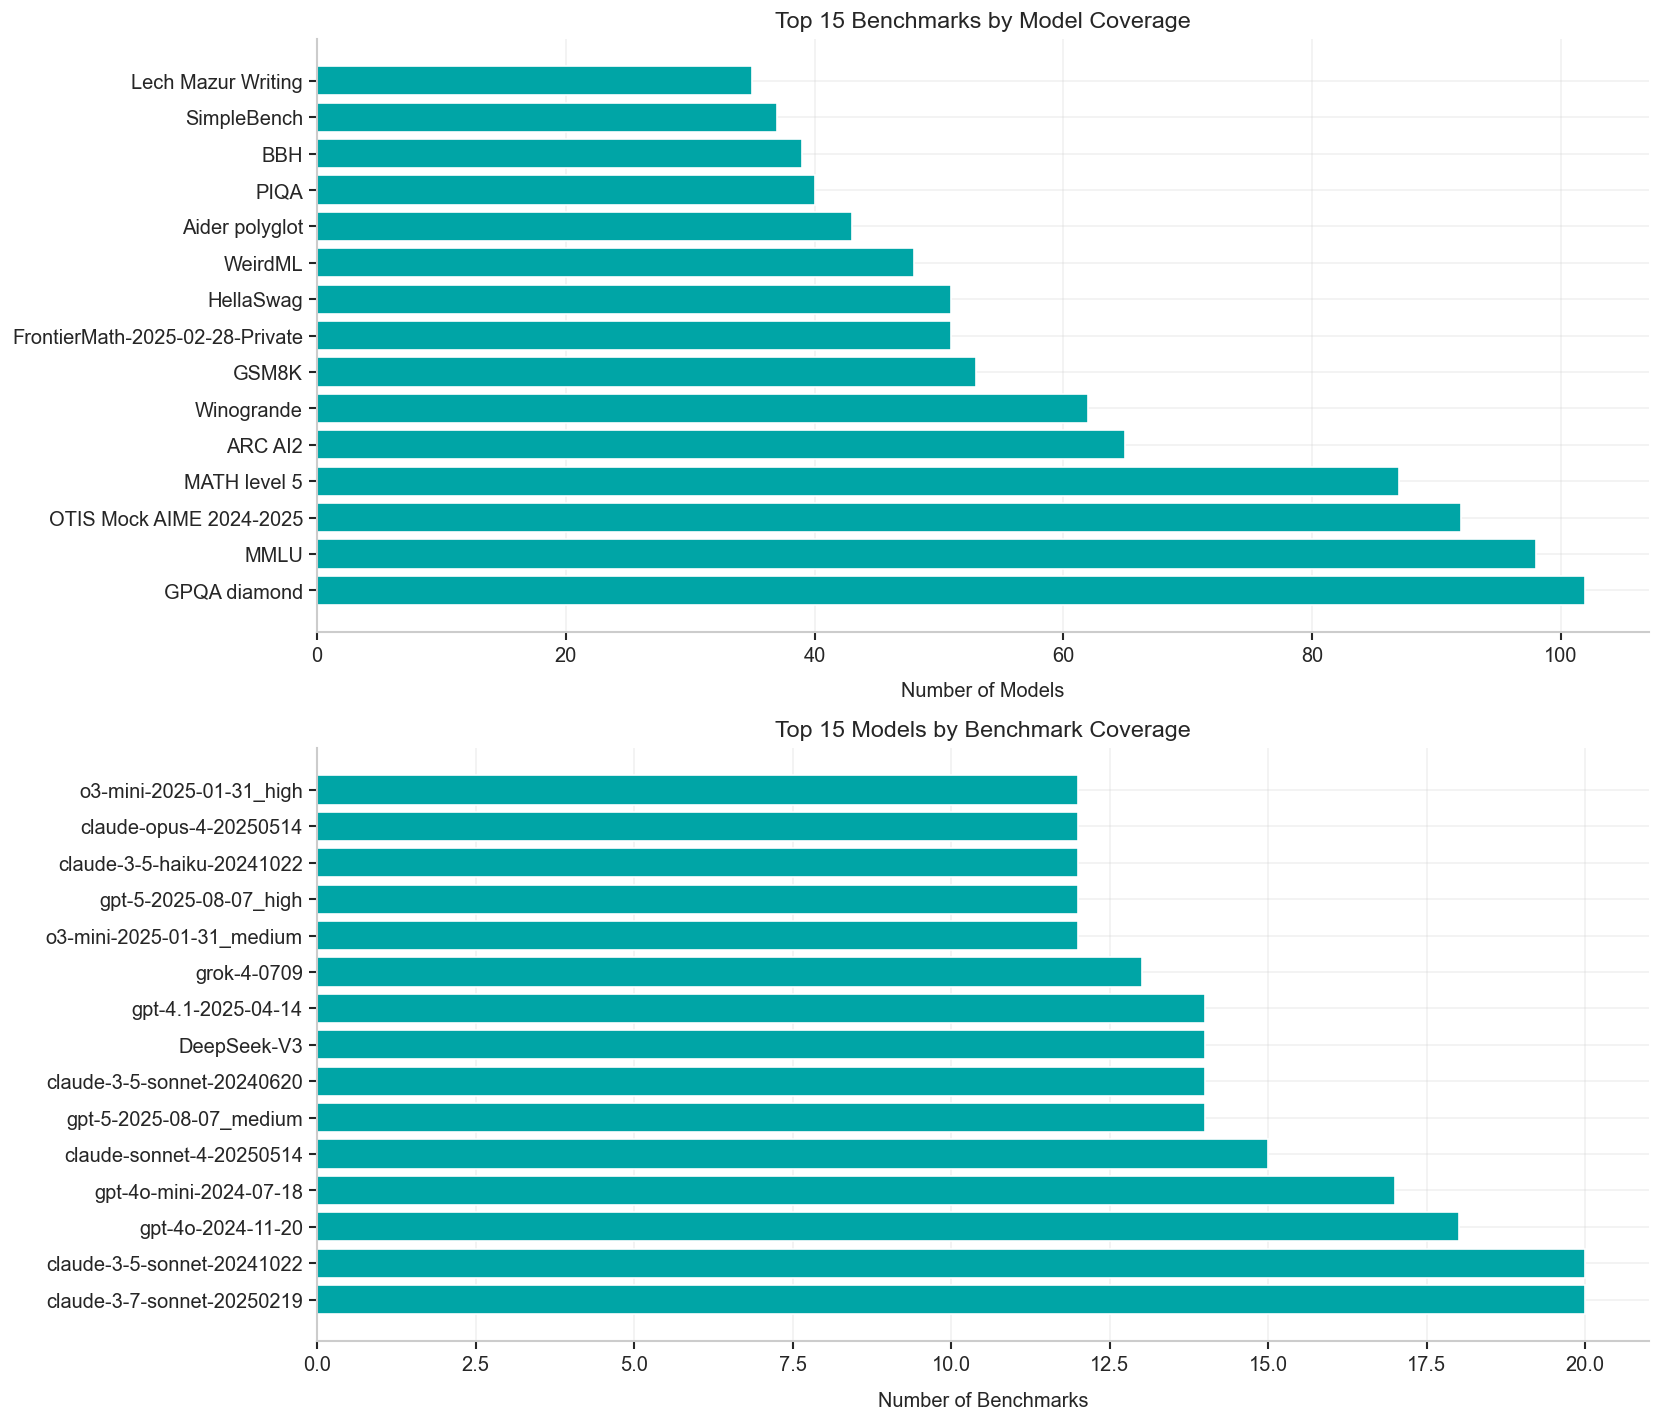

In [4]:
# Overlap matrix and coverage (create_overlap_matrix + analyze_benchmark_coverage)

# Model-benchmark matrix (count of records per model-benchmark)
model_benchmark_matrix = scores_df.pivot_table(
    index='model',
    columns='benchmark',
    values='performance',
    aggfunc='count',
    fill_value=0
)

# Binary presence matrix
model_benchmark_binary = (model_benchmark_matrix > 0).astype(int)

# Overlap matrix: common models between benchmark pairs
overlap_matrix = model_benchmark_binary.T @ model_benchmark_binary

# Heatmap (lower triangle)
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(overlap_matrix), k=1)
sns.heatmap(
    overlap_matrix,
    mask=mask,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    ax=ax,
    cbar_kws={"shrink": .8}
)
ax.set_title('Benchmark Overlap Matrix\n(Number of Common Models)', fontsize=14)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Benchmark')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs/data_exploration/benchmark_overlap_matrix.pdf", dpi=300, bbox_inches='tight')
# plt.savefig('outputs/figures/figure-10.svg', format='svg')

# Coverage stats
models_per_benchmark = model_benchmark_binary.sum(axis=0).sort_values(ascending=False)
benchmarks_per_model = model_benchmark_binary.sum(axis=1).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
# Top benchmarks by model count
top_benchmarks = models_per_benchmark.head(15)
ax1.barh(range(len(top_benchmarks)), top_benchmarks.values)
ax1.set_yticks(range(len(top_benchmarks)))
ax1.set_yticklabels(top_benchmarks.index)
ax1.set_xlabel('Number of Models')
ax1.set_title('Top 15 Benchmarks by Model Coverage')
ax1.grid(True, alpha=0.3, axis='x')

# Top models by benchmark count
top_models = benchmarks_per_model.head(15)
ax2.barh(range(len(top_models)), top_models.values)
ax2.set_yticks(range(len(top_models)))
ax2.set_yticklabels(top_models.index)
ax2.set_xlabel('Number of Benchmarks')
ax2.set_title('Top 15 Models by Benchmark Coverage')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("outputs/data_exploration/benchmark_coverage_analysis.pdf", dpi=300, bbox_inches='tight')


{
    'most_covered_benchmark': (models_per_benchmark.index[0], int(models_per_benchmark.iloc[0])) if len(models_per_benchmark) else None,
    'most_evaluated_model': (benchmarks_per_model.index[0], int(benchmarks_per_model.iloc[0])) if len(benchmarks_per_model) else None
}


# Fraction of models that are notable (Appendix B: Data)

In [9]:
# Fraction of models in scores_df that are notable per Epoch all_ai_models (using model name mapping)
import pandas as pd

# Map model IDs in scores_df to human-readable names using model_versions.csv
_mv = pd.read_csv("data/model_versions.csv")[["id", "Model"]].rename(columns={"id": "model"})
_unique_ids = scores_df[["model"]].drop_duplicates()
_unique_with_names = _unique_ids.merge(_mv, on="model", how="left")

# Use the mapped name when available; fall back to the ID string
_unique_with_names["model_name"] = _unique_with_names["Model"].fillna(_unique_with_names["model"].astype(str))
_unique_with_names["model_norm"] = _unique_with_names["model_name"].astype(str).str.lower().str.strip()

# Load Epoch's all_ai_models.csv and normalize
_df_all = pd.read_csv("https://epoch.ai/data/all_ai_models.csv")
_name_candidates = [
    "Model", "Name", "Model name", "Model Name", "model", "name", "model_name"
]
_name_col = next((c for c in _name_candidates if c in _df_all.columns), None)

if _name_col is None:
    print("Could not find a model name column in all_ai_models.csv; available columns:")
    print(list(_df_all.columns))
else:
    _df_all = _df_all.copy()
    _df_all["model_norm"] = _df_all[_name_col].astype(str).str.lower().str.strip()
    _df_all_norm = _df_all[["model_norm", "Notability criteria", _name_col]].drop_duplicates(subset=["model_norm"])

    # Merge normalized names to attach notability
    _merged = _unique_with_names.merge(_df_all_norm, on="model_norm", how="left")
    _merged["is_notable"] = _merged["Notability criteria"].notna()

    _total = len(_merged)
    _num_notable = int(_merged["is_notable"].sum())
    _frac_notable = _num_notable / _total if _total else float("nan")

    print(f"Unique model IDs in scores_df: {_total}")
    print(f"Models with non-NaN 'Notability criteria': {_num_notable}")
    print(f"Fraction notable: {_frac_notable:.3f}")

    # Diagnostics
    _num_missing_names = int(_unique_with_names["Model"].isna().sum())
    if _num_missing_names:
        print(f"Warning: {_num_missing_names} model IDs lacked a name in model_versions.csv (using ID as fallback).")

    _missing_examples = _merged.loc[~_merged["is_notable"], "model_name"].head(20).tolist()
    if _missing_examples:
        print("Examples without 'Notability criteria':", _missing_examples)



Unique model IDs in scores_df: 179
Models with non-NaN 'Notability criteria': 99
Fraction notable: 0.553
Examples without 'Notability criteria': ['o4-mini', 'Gemini 2.5 Flash', 'Gemini 2.5 Flash', 'DeepSeek-V3.1', 'Gemini 2.0 Flash', 'phi-3-small 7.4B', 'Phi-2', 'Mistral 7B', 'Gemma 7B', 'Yi 6B', 'Yi-9B', 'PaLM 2-S', 'PaLM 2-M', 'PaLM 2-L', 'Falcon-7B', 'MPT-7B', 'chatglm2-6b', 'internlm-7b', 'internlm-20b', 'Baichuan 2-7B']


# Figure 17: Temporal distribution of benchmark entries (Appendix B Data)

,year_month,count,date
0,2023-02,42,2023-02-01
1,2023-03,22,2023-03-01
2,2023-04,28,2023-04-01
3,2023-05,30,2023-05-01
4,2023-06,43,2023-06-01
5,2023-07,59,2023-07-01
6,2023-08,4,2023-08-01
7,2023-09,54,2023-09-01
8,2023-11,41,2023-11-01
9,2023-12,17,2023-12-01


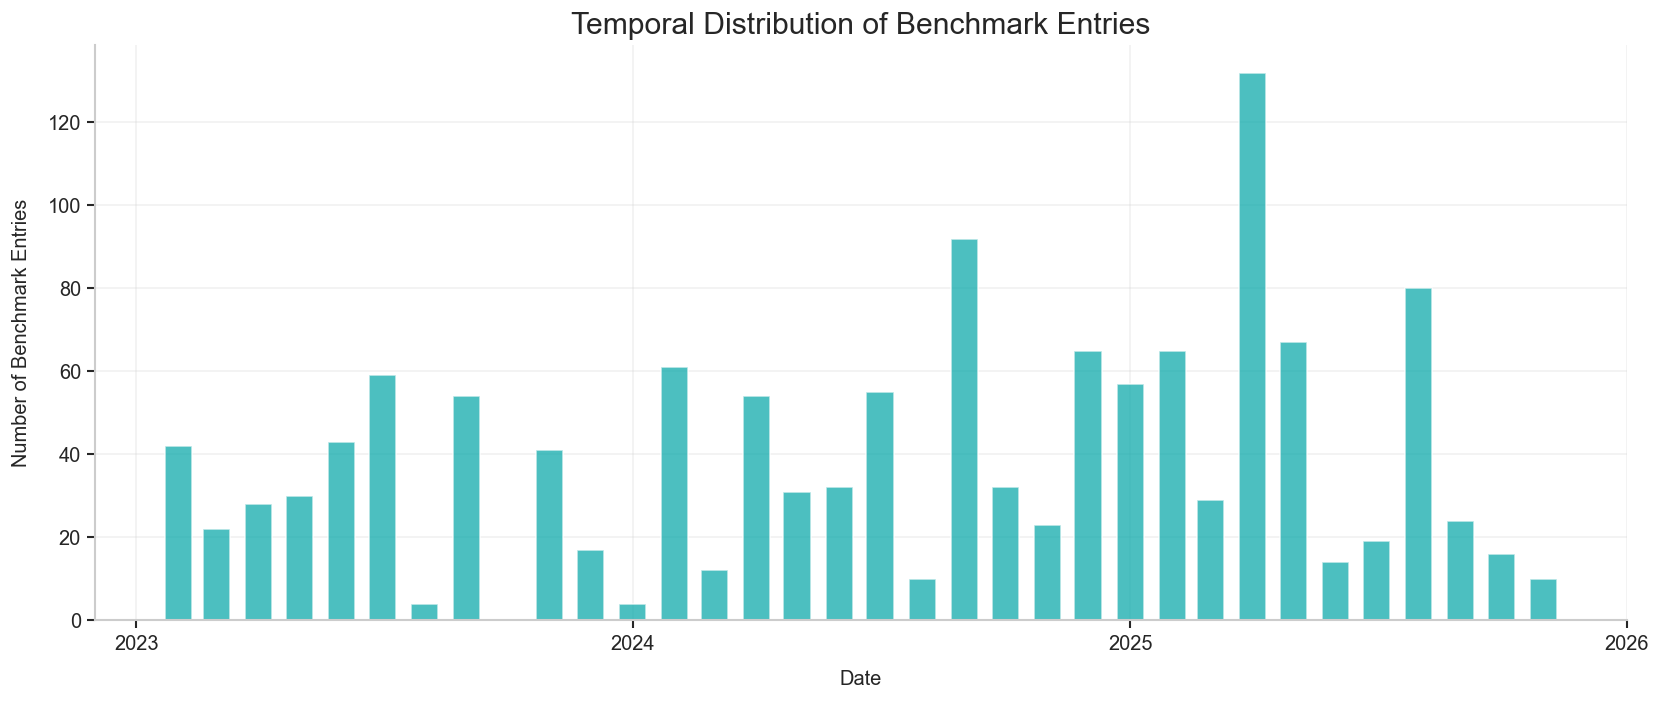

In [7]:
# Temporal distribution (analyze_temporal_distribution)

df = scores_df.copy()
df['date_obj'] = pd.to_datetime(df['date'])
df['year_month'] = df['date_obj'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_counts['date'] = monthly_counts['year_month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_counts['date'], monthly_counts['count'], width=20, alpha=0.7, color=colors[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Benchmark Entries')
ax.set_title('Temporal Distribution of Benchmark Entries', fontsize=18)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# Format dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/data_exploration/temporal_distribution.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('outputs/figures/figure-18.svg', format='svg')

monthly_counts.head(10)


# Graphs for video and blogpost

/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_10615/2362962769.py:56: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  for label in ax.get_xticklabels():
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_10615/2362962769.py:62: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  for lbl in ax.get_xticklabels():
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_10615/2362962769.py:68: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/dn/nknbl4x9401_pvgx

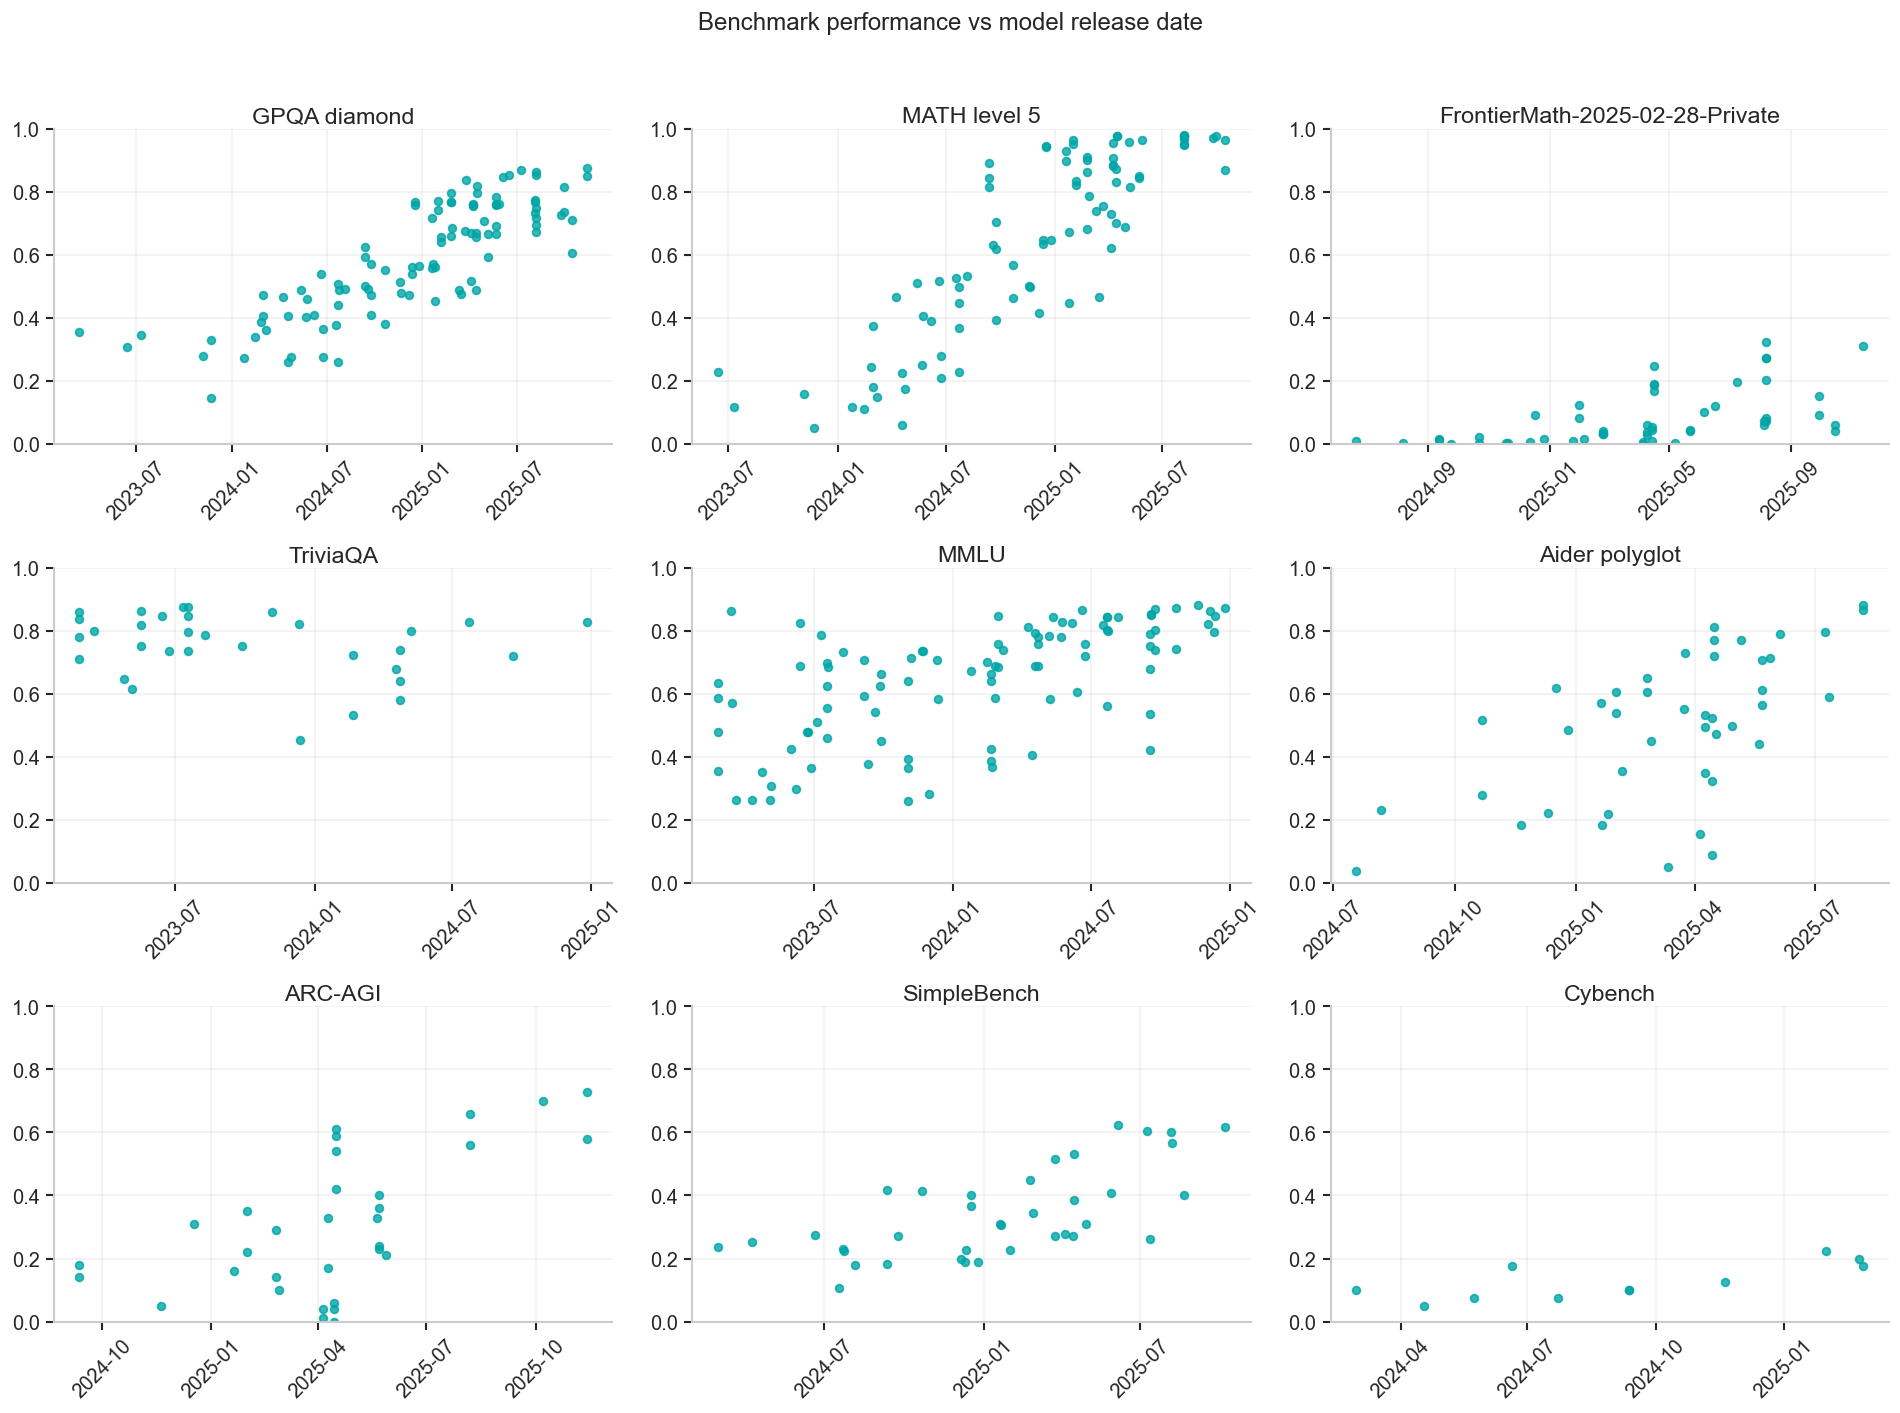

In [6]:
# 3x3 grid: Benchmark performance vs time for selected benchmarks (or random if none specified)
import numpy as np

# Prepare data
_df = scores_df.copy()
_df['date_parsed'] = pd.to_datetime(_df['date'], errors='coerce')

# Specify benchmarks to include (edit this list). If empty, a random selection will be used.
user_selected_benchmarks = [
    "GPQA diamond", "MATH level 5", "FrontierMath-2025-02-28-Private", 
    "TriviaQA", "MMLU", "Aider polyglot",
    "ARC-AGI", "SimpleBench", "Cybench"
]

rng = np.random.default_rng(0)
unique_benchmarks = _df['benchmark'].dropna().unique().tolist()

if len(user_selected_benchmarks) > 0:
    # Validate and keep only those present
    selected_clean = [b for b in user_selected_benchmarks if b in unique_benchmarks]
    missing = [b for b in user_selected_benchmarks if b not in unique_benchmarks]
    if missing:
        print(f"Warning: {len(missing)} benchmarks not found and will be skipped: {missing}")
    selected_benchmarks = np.array(selected_clean)
else:
    # Fallback to random nine
    num_to_draw = min(9, len(unique_benchmarks))
    selected_benchmarks = rng.choice(unique_benchmarks, size=num_to_draw, replace=False)

# Cap at 9 for a 3x3 grid
if len(selected_benchmarks) > 9:
    print(f"Note: More than 9 specified; showing the first 9: {selected_benchmarks[:9].tolist()}")
    selected_benchmarks = selected_benchmarks[:9]

num_to_plot = len(selected_benchmarks)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= num_to_plot:
        fig.delaxes(ax)
        continue
    bench = selected_benchmarks[i]
    sub = (
        _df[_df['benchmark'] == bench]
        .dropna(subset=['date_parsed', 'performance'])
        .sort_values('date_parsed')
    )
    ax.scatter(sub['date_parsed'], sub['performance'], s=22, alpha=0.8)
    ax.set_title(str(bench))
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.grid(True, alpha=0.3)

    # Ensure tick labels show on all subplots (not just edge axes)
    ax.tick_params(labelbottom=True, labelleft=True)
    for lbl in ax.get_xticklabels():
        lbl.set_visible(True)
    for lbl in ax.get_yticklabels():
        lbl.set_visible(True)

fig.suptitle('Benchmark performance vs model release date')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("outputs/notebooks/benchmark_performance_vs_time_grid.pdf", dpi=300, bbox_inches='tight')
plt.show()
